<h1 style='text-align: center'>Movies recommendation</h1></br>

Given some data about movies, users and ratings, the goal is to deliver a movie recommendation algorithm using some machine learning methods.

In [1]:
# Importing usefull packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import roc_curve
from sklearn.ensemble import GradientBoostingClassifier as Boost
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN

Data coming from  https://grouplens.org/datasets/movielens/

In [2]:
# load files
df_movies = pd.read_csv('ml-latest-small/movies.csv', index_col=0)
df_ratings = pd.read_csv('ml-latest-small/ratings.csv')
df_tags = pd.read_csv('ml-latest-small/tags.csv')

### movies.csv

In [3]:
df_movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


### ratings.csv

In [4]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### tags.csv

In [5]:
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## Getting started and pre-treatment  

We try to format the data to make them exploitable by machine learning methods.

### Ratings as movie/user matrix

In [6]:
df_ratings = df_ratings.pivot("movieId","userId","rating").fillna(0)

print(df_ratings.shape)
df_ratings.head()

(9724, 610)


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


### Movies with genres binarisation 

In [7]:
df_movies = pd.concat([df_movies, df_movies['genres'].str.get_dummies(sep="|")], axis=1)
df_movies = df_movies.drop(['genres'], axis=1)

df_movies['date'] = df_movies["title"].str.extract("\((\d\d\d\d)\)").fillna(2019)
df_movies = df_movies.drop(['title'], axis=1)

# Adding total number of rates and mean rate
df_movies['ratingNumber'] = (df_ratings>0).sum(axis=1)
df_movies['mean rating'] = df_ratings.sum(axis=1)/(df_movies['ratingNumber'])

df_movies = df_movies.fillna(0)

print(df_movies.shape)
df_movies.head()

(9742, 23)


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,date,ratingNumber,mean rating
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1995,215.0,3.920930
2,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1995,110.0,3.431818
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1995,52.0,3.259615
4,0,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1995,7.0,2.357143
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1995,49.0,3.071429


### Some interesting plots  
  
Some graphs can help to already better analyze all the data.

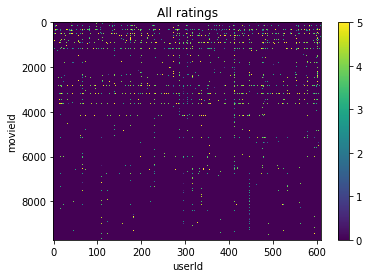

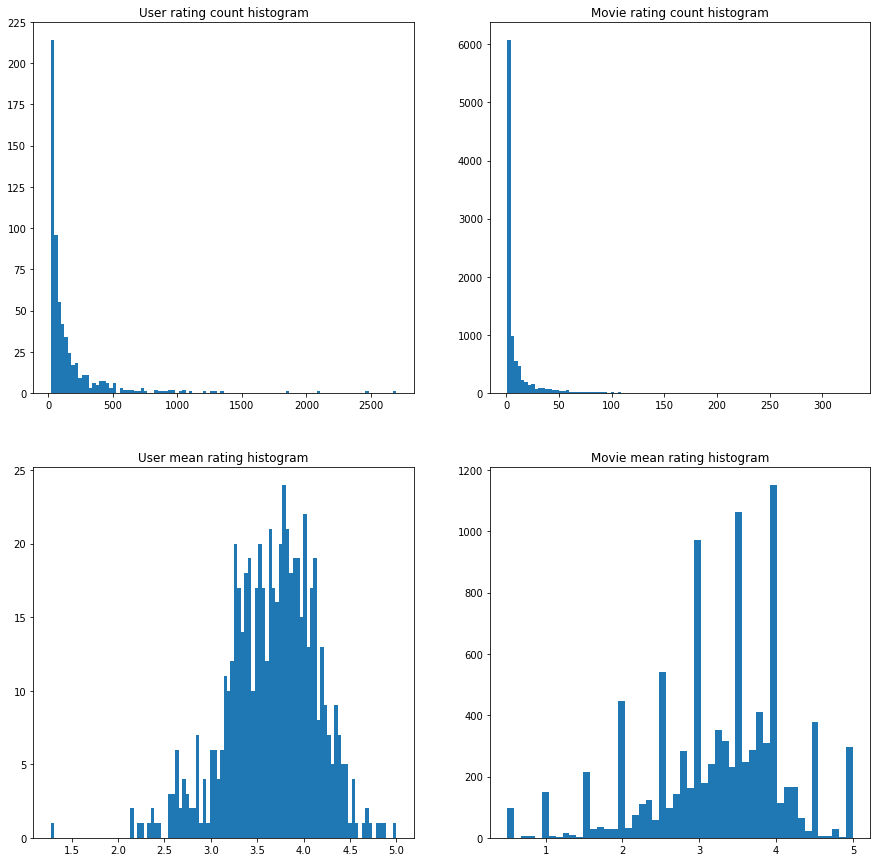

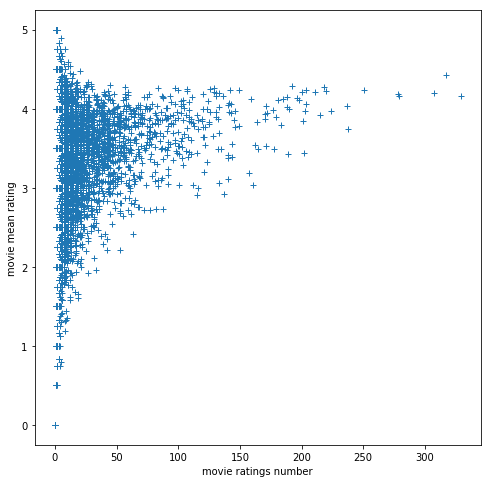

In [8]:
# Total number of rates for a specific user or movie
user_nb_rating=(df_ratings>0).sum(0)
movie_nb_rating = (df_ratings>0).sum(1)

# Mean rate for a specific user or movie 
mean_user_rating = df_ratings.sum(0)/(user_nb_rating+0.000001)
mean_movie_rating = df_ratings.sum(1)/(movie_nb_rating+0.000001)

# Plots
plt.imshow(df_ratings,aspect="auto",interpolation=None)
plt.xlabel('userId')
plt.ylabel('movieId')
plt.title('All ratings')
plt.colorbar()

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.hist(user_nb_rating,bins=100)
plt.title('User rating count histogram')

plt.subplot(222)
plt.hist(movie_nb_rating,bins=100)
plt.title('Movie rating count histogram')

plt.subplot(223)
plt.hist(mean_user_rating,bins=100)
plt.title('User mean rating histogram')

plt.subplot(224)
plt.hist(mean_movie_rating,bins=50)
plt.title('Movie mean rating histogram')

plt.figure(figsize=(8,8))
plt.plot(df_movies['ratingNumber'],df_movies['mean rating'],"+")
plt.xlabel('movie ratings number')
plt.ylabel('movie mean rating')

plt.show()

## Classical classification algorithms and implementation of evaluation protocols  
  
We're going to classify a movie as "good" or "bad" according to the median rating

In [9]:
X = df_movies.iloc[:,:-2].values
y = df_movies.iloc[:,-1].values

threshold = np.median(y)

y = np.where(y > threshold, 1, -1)

### Train/test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Cross validation method using GridSearch

In [11]:
def crossval(X, y, clf, list_params, cv=5):
    grid = GridSearchCV(clf, list_params, cv=cv, scoring="roc_auc")
    grid.fit(X, y)
    return grid

### ROC curve for random forest, gradient boosting and KNN classifier

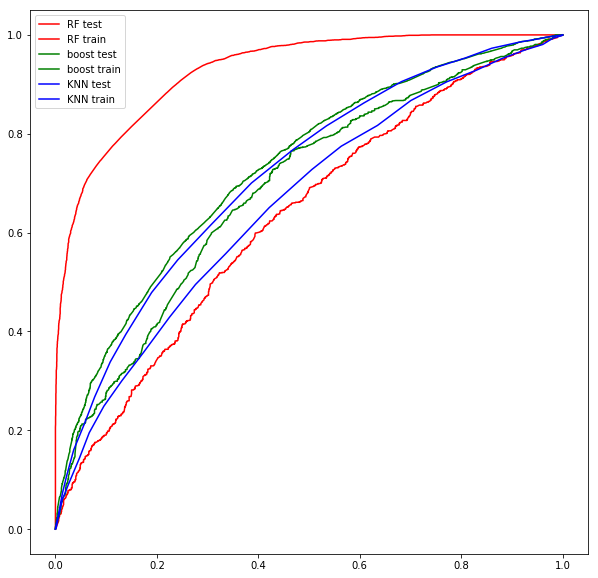

In [12]:
# Random Forest classifier
best_RF = crossval(X_train, y_train, RF(), {"n_estimators":[10,50,100,200,400,600]}, 10)

# Gradient boosting classifier
best_Boost = crossval(X_train, y_train, Boost(), {"n_estimators":[10,50,100,200,400,600]}, 10)

# K Nearest Neighbors classifier
best_KNN = crossval(X_train, y_train, KNN(), {"n_neighbors":[3,5,9,15,20,30,50]}, 10)

# Plot ROC curve
plt.figure(figsize=(10,10))
for clf, name, c in [(best_RF,"RF","r"), (best_Boost,"boost","g"), (best_KNN,"KNN","b")]:
    # Test
    fpr, tpr, ths = roc_curve(y_test, clf.predict_proba(X_test)[:,1].reshape(-1,1))
    plt.plot(fpr, tpr, label=name+" test", color=c)
    
    # Train
    fpr, tpr, ths = roc_curve(y_train, clf.predict_proba(X_train)[:,1].reshape(-1,1))
    plt.plot(fpr, tpr, label=name+" train", color=c)
plt.legend(loc="best")